# Intel Image Classification using CNN

## Define the problem 
### What is the input data
- For this project, I utilized the Intel Image dataset. The dataset can be accessed through the following link: [Intel Image Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification). This dataset comprises multiple images in JPG format, which are to be processed to serve as input for our deep learning model.
### What type of problem 
- The problem at hand is a multilabel classification task. Within the dataset, each image is associated with one of six distinct labels: 'buildings', 'forest', 'glacier', 'mountain', 'sea', and 'street'. Our objective is to develop a model capable of accurately identifying the labels associated with each image.
### What are you hoping to predict 
- The goal is to predict the appropriate labels for the images within the dataset. 

## Choosing measure of success -rewrite
To evaluate the model's success, I'll consider four key metrics: Accuracy, Precision, Recall and ROC AUC. 

Since this is a data set with multiple labels, for a more meaningful evaluation I would use categorical accuracy, which evaluates each label independently and provides a better insight into the effectiveness of the model in predicting each label category.
Precision measures the proportion of correctly predicted positive cases out of all predicted positive cases and provides insight into the model's ability to avoid false positives.
Recall measures the proportion of correctly predicted positive cases out of all positive cases and indicates the model's ability to capture all positive instances.
In addition, the ROC AUC measures the model's ability to effectively distinguish between classes.
These four metrics make the model's ability very clear.

## Deciding on an evaluation protocol 
For the evaluation protocol, I will use a k cross validation approach. 


This involves splitting the dataset into training and validation sets The model will be trained on the training set and then evaluated on the validation set to assess its performance. Additionally, grid search will be combined to this process to try various hyperparameters and determine the optimal hyperparameters for the model.

In [3]:
# Necessary libraries
import os
import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
import itertools

from glob import glob
from PIL import Image
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from keras.models import Sequential  
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

## Loading the dataset 

In [4]:
image_size = (150, 150)
my_seed=42

# directories to train and test set
folder_urls = ['../ML_FINAL_TERM/intel_dataset/seg_train/seg_train','../ML_FINAL_TERM/intel_dataset/seg_test/seg_test']

In [5]:
def load_dataset(data_dir):
    """
    Load images and their corresponding labels from folder name 

    parameters:
    data_dir: directory to the dataset 

    returns: 
            two arrays: 
           - X_images: an array of image data
           - y_labels: an array of corresponding labels
    """
    X_images = []
    y_labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)

        for filename in glob(os.path.join(folder_path, '*.jpg')):
            img_path = filename
            image = Image.open(img_path)
            image = image.convert('RGB')
            image = image.resize(image_size)  
            X_images.append(np.array(image))
            y_labels.append(folder)

    return np.array(X_images), np.array(y_labels)

In [6]:
X_image_train, y_label_train= load_dataset(folder_urls[0])
train_images, train_labels = shuffle(X_image_train, y_label_train, random_state=my_seed)

In [7]:
X_image_test, y_label_test= load_dataset(folder_urls[1])
test_images, test_labels = shuffle(X_image_test, y_label_test, random_state=my_seed)

In [8]:
# train set further divided to validation and train set 
X_image_train,X_image_val,y_label_train, y_label_val = train_test_split(X_image_train,y_label_train,
                                                                        test_size=0.25,
                                                                        shuffle=True,
                                                                        stratify=y_label_train,
                                                                        random_state=my_seed)

In [9]:
print('Train Images Shape:      ', X_image_train.shape)
print('Train Labels Shape:      ', y_label_train.shape)

print('\nValidation Images Shape: ', X_image_val.shape)
print('Validation Labels Shape: ', y_label_val.shape)

print('\nTest Images Shape:       ', X_image_test.shape)
print('Test Labels Shape:       ', y_label_test.shape)

Train Images Shape:       (10525, 150, 150, 3)
Train Labels Shape:       (10525,)

Validation Images Shape:  (3509, 150, 150, 3)
Validation Labels Shape:  (3509,)

Test Images Shape:        (3000, 150, 150, 3)
Test Labels Shape:        (3000,)


## Explore the dataset

The dataset include six different labels . 

In [8]:
total_labels = np.unique(y_label_test)
print(total_labels)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


### Class Distribution

In [9]:
def plot_class_distribution(y_train, class_names):
    """
    ploot the class distribution of the training set

    parameters:
    y_train     : labels of the training set.
    class_names : list of unique class labels

    returns: -
    display the bar chart and pie chart
    """
    train_counts = pd.Series(y_train).value_counts().reindex(class_names, fill_value=0)
    colors = ['#3F75A8','#9DC639','#94ECF4','#485838','#3F89E7','#7C7C7C']
    
    ax = train_counts.plot(kind='bar', figsize=(8, 5), color=colors)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() * 1.01),
                    ha='center', va='bottom')
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(train_counts, labels=train_counts.index, autopct='%1.1f%%', colors=colors, explode=[0.05] * len(train_counts))
    ax.set_title('Class Distribution in Training Set')
    
    plt.show()

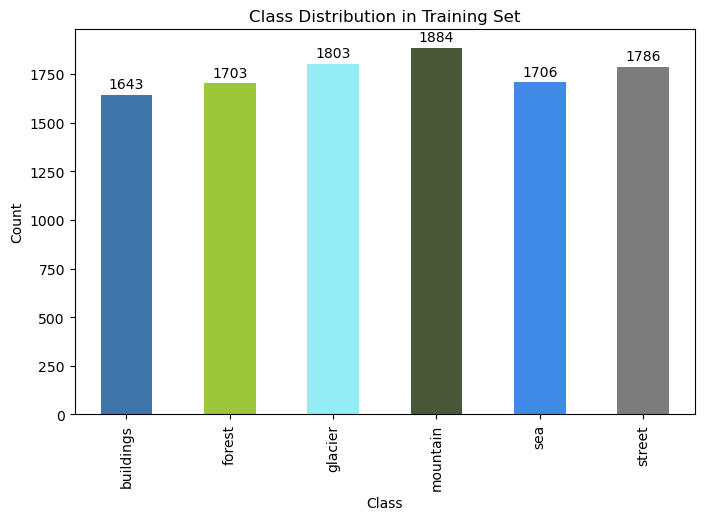

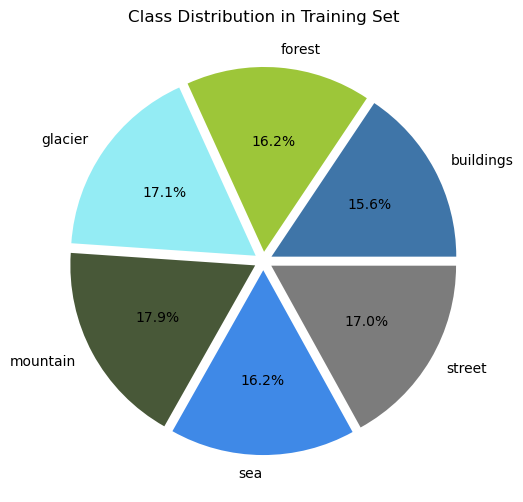

In [10]:
plot_class_distribution(y_label_train,total_labels)

In [11]:
def display_images_by_class(x_train, y_train, classes):
    """
    show sample images for each class in the dataset

    parameters:
    x_train : array containing the training images
    y_train : array containing the labels of the images
    classes : list of unique class labels

    returns: -
    display the sample images
    """
    num_classes = len(classes)
    for cls in classes: 
        class_indices = np.where(y_train == cls)[0][:5]
        
        print(f"Displaying images for Label: {cls}")
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(f"Label: {cls}")
        
        for i, index in enumerate(class_indices):
            axes[i].imshow(x_train[index])
            axes[i].axis('off')
        
        plt.show()

Displaying images for Label: buildings


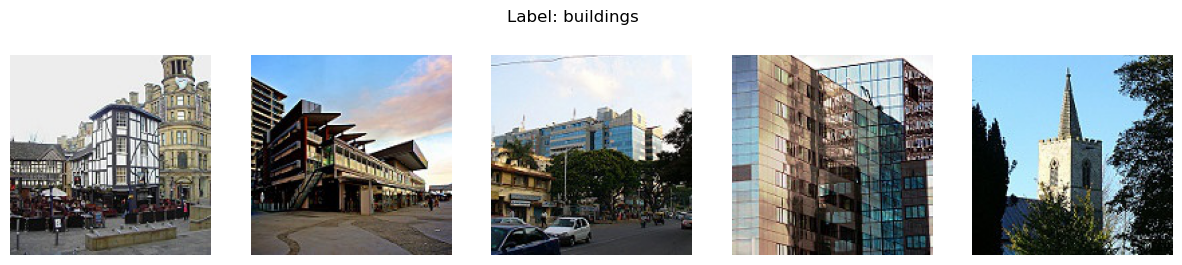

Displaying images for Label: forest


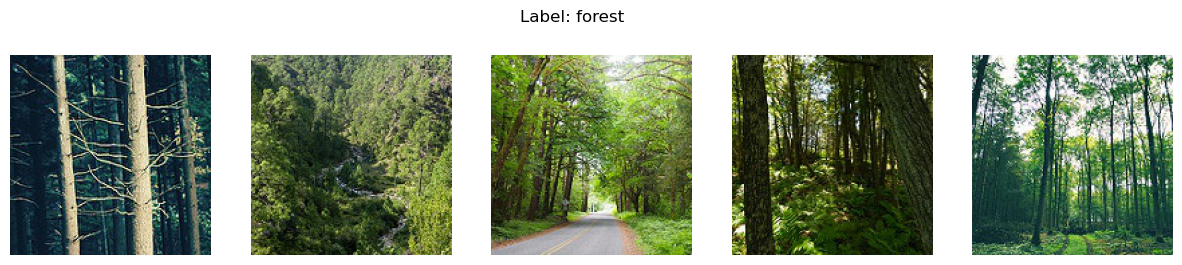

Displaying images for Label: glacier


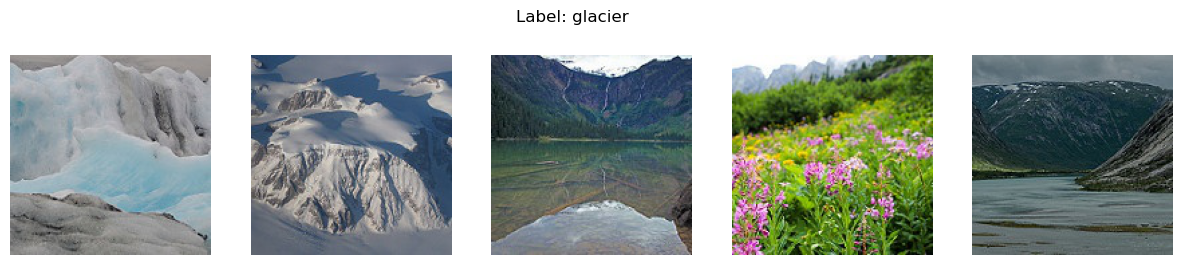

Displaying images for Label: mountain


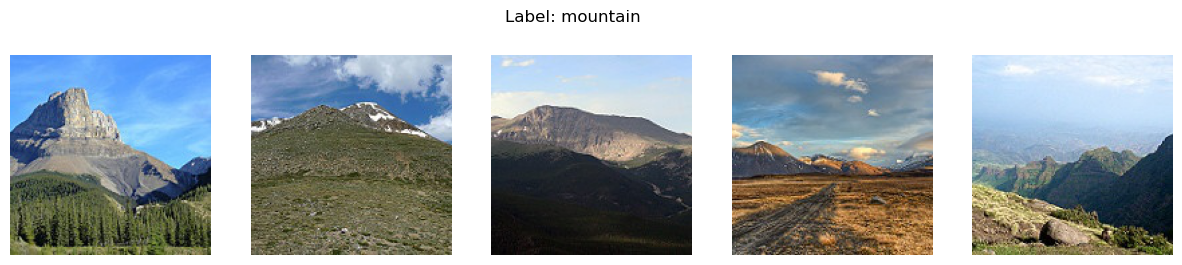

Displaying images for Label: sea


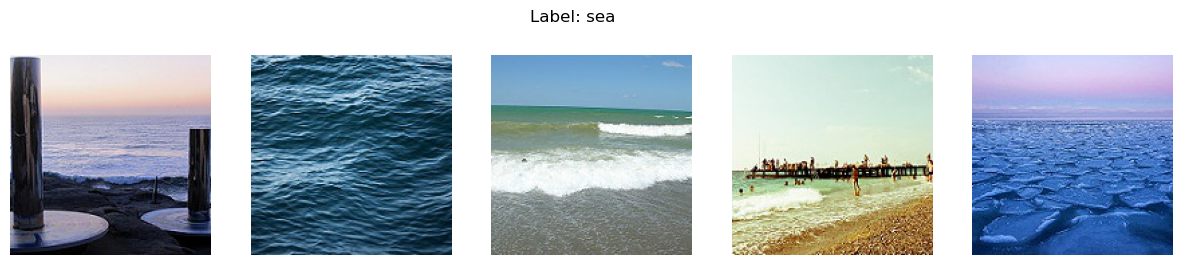

Displaying images for Label: street


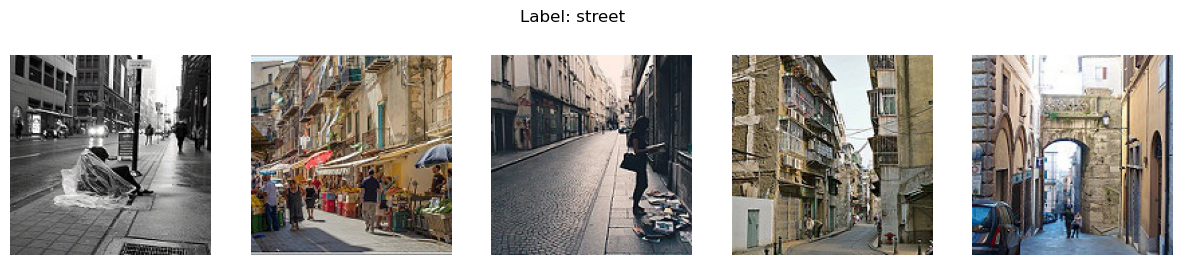

In [12]:
display_images_by_class(X_image_train,y_label_train,total_labels)

## Preparing you data  

In the preprocessing stage, the image data is first flattened. This reshaping process converts the images from their original 3D format to 1D arrays while keeping the essential information. Subsequently, the Min-Max scaling technique is applied to normalize the feature values within a specific range of 0 to 1, enhancing model stability and convergence. Lastly, the categorical class labels undergo one-hot encoding to represent them as binary vectors, ensuring compatibility with classification algorithms. 

In [17]:
# Flatten images
X_image_train_flattened = X_image_train.reshape(X_image_train.shape[0], -1)
X_image_val_flattened = X_image_val.reshape(X_image_val.shape[0], -1)
X_image_test_flattened = X_image_test.reshape(X_image_test.shape[0], -1)
print('Shape before flattening: ',X_image_train[0].shape)
print('Shape after flattening: ',X_image_train_flattened[0].shape)

# Min-Max scaling
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_image_train_flattened)
X_val= scaler.transform(X_image_val_flattened)
X_test = scaler.transform(X_image_test_flattened)
print('Before scaling: ',X_image_train_flattened[0])
print('After scaling: ',X_train[0])

Shape before flattening:  (150, 150, 3)
Shape after flattening:  (67500,)
Before scaling:  [150 146 143 ... 114 119 122]
After scaling:  [0.58823529 0.57254902 0.56078431 ... 0.44705882 0.46666667 0.47843137]


In [18]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train= onehot_encoder.fit_transform(y_label_train.reshape(-1, 1))
y_val= onehot_encoder.transform(y_label_val.reshape(-1, 1))
y_test= onehot_encoder.transform(y_label_test.reshape(-1, 1))
print('Before one hot encoding: ', y_label_train[0])
print('After one hot encoding : ', y_train[0])

Before one hot encoding:  glacier
After one hot encoding :  [0. 0. 1. 0. 0. 0.]


## Setting baseline

The baseline is set using majority class baseline 

In [15]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_label_train)
all_labels = np.concatenate((y_label_train,y_label_val,y_label_test))
encoded_labels = label_encoder.transform(all_labels) 

class_counts= np.bincount(encoded_labels)
most_common_class = np.argmax(class_counts)

classes=[0,1,2,3,4,5]
counts = pd.DataFrame({'Class': classes, 'Counts': class_counts})
display(counts)

print('Most common class: ', most_common_class, '(Mountains)')

,Class,Counts
0,0,2628
1,1,2745
2,2,2957
3,3,3037
4,4,2784
5,5,2883


Most common class:  3 (Mountains)


In [16]:
# Baseline accuracy 
print(f'Accuracy: {(class_counts[3] / len(all_labels) * 100):.2f}%')

Accuracy: 17.83%


## Developing a model that does better than a baseline

In [10]:
def set_up_dnn_model(hidden_layers=0,neurons=None,
                     activation=None,dropout=None,
                     input_dimension=None, 
                     output_dimension=None,
                     metrics=['accuracy'],
                     name=None):
    """
    Creates a DNN model with specified architecture and parameters

    parameters:
    hidden_layers   (int): number of hidden layers in the model
    neurons         (int): number of neurons in each hidden layer
    activation      (str): activation function to use in hidden layers
    dropout       (float): dropout rate to apply in hidden layers
    input_dimension (int): dimensionality of the input data
    output_dimension(int): dimensionality of the output data
    metrics        (list): liist of metrics
    name            (str): name for the model(optional)

    returns: Compiled DNN model
    """
    
    model = Sequential()
    if hidden_layers > 0:
        for layer in range(hidden_layers):
            if neurons is not None:
                model.add(Dense(neurons, activation=activation, input_shape=(input_dimension,)))
            if dropout is not None:
                model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, activation='softmax', input_shape=(input_dimension,)))
  
    if name is not None:
        model._name = name

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=metrics)
    
    return model

In [26]:
def train_dnn(model, train_X, train_y,
                      val_X, val_y, 
                      batch_size=32, epochs=50, 
                      callbacks=[]) :
    """
    Trains the DNN model

    parameters:
    model    (Sequential): DNN model to train
    train_X  (array): training data
    train_y  (array): labels of the training data
    val_X    (array): validation data
    val_y    (array): labels of the validation data
    batch_size (int): number of samples per gradient update
    epochs     (int): number of epochs 
    callbacks (list): callbacks to apply during training (optional)

    returns:
    dict: a dictionary containing the trained model, validation score, and training history
    """
    history = model.fit(train_X, train_y,
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_data=(val_X, val_y),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [12]:
def plot_training(history):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    loss_ax = axes[0]
    accuracy_ax = axes[1]

    loss_ax.plot(history['loss'], label='Train Loss')
    loss_ax.plot(history['val_loss'], label='Validation Loss')
    loss_ax.set_title('Model Loss')
    loss_ax.set_ylabel('Loss')
    loss_ax.set_xlabel('Epoch')
    loss_ax.legend()

    accuracy_ax.plot(history['categorical_accuracy'], label='Train Accuracy')
    accuracy_ax.plot(history['val_categorical_accuracy'], label='Validation Accuracy')
    accuracy_ax.set_title('Model Accuracy')
    accuracy_ax.set_ylabel('Accuracy')
    accuracy_ax.set_xlabel('Epoch')
    accuracy_ax.legend()

    plt.tight_layout()
    plt.show()

In [20]:
# metrics: accuracy, precision, recall , auc
multi_metrics = ['categorical_accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='AUC', multi_label=True)]

input_dim = X_train.shape[1]
output_class = y_train.shape[1]
print('Input dimension: ', input_dim, '\nOutput dimension: ',output_class)

2024-02-19 20:36:56.564067: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-19 20:36:56.564359: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-19 20:36:56.564375: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-19 20:36:56.565010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 20:36:56.565330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Input dimension:  67500 
Output dimension:  6


In [21]:
btb_model = set_up_dnn_model(hidden_layers=1,
                            input_dimension=input_dim,
                            output_dimension=output_class,
                            metrics=multi_metrics,
                            name='Model_better_than_baseline')

In [22]:
btb_model.summary()

Model: "Model_better_than_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 405006    
                                                                 
Total params: 405006 (1.54 MB)
Trainable params: 405006 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20, verbose=1)

In [24]:
trained_btb_model = train_dnn(btb_model,
                              X_train, y_train,
                              X_val, y_val,
                              callbacks=[early_stopping])

2024-02-19 19:16:20.718035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [25]:
print('Accuracy   : {:.2f}% - (beats the baseline accuracy of 17.83%)'.format(trained_btb_model['val_score'][0]*100))
print('Precision  : {:.2f}%'.format(trained_btb_model['val_score'][1]*100))
print('Recall     : {:.2f}%'.format(trained_btb_model['val_score'][2]*100))
print('AUC        : {:.2f}%'.format(trained_btb_model['val_score'][3]*100))

Accuracy   : 36.22% - (beats the baseline accuracy of 17.83%)
Precision  : 36.26%
Recall     : 36.22%
AUC        : 64.77%


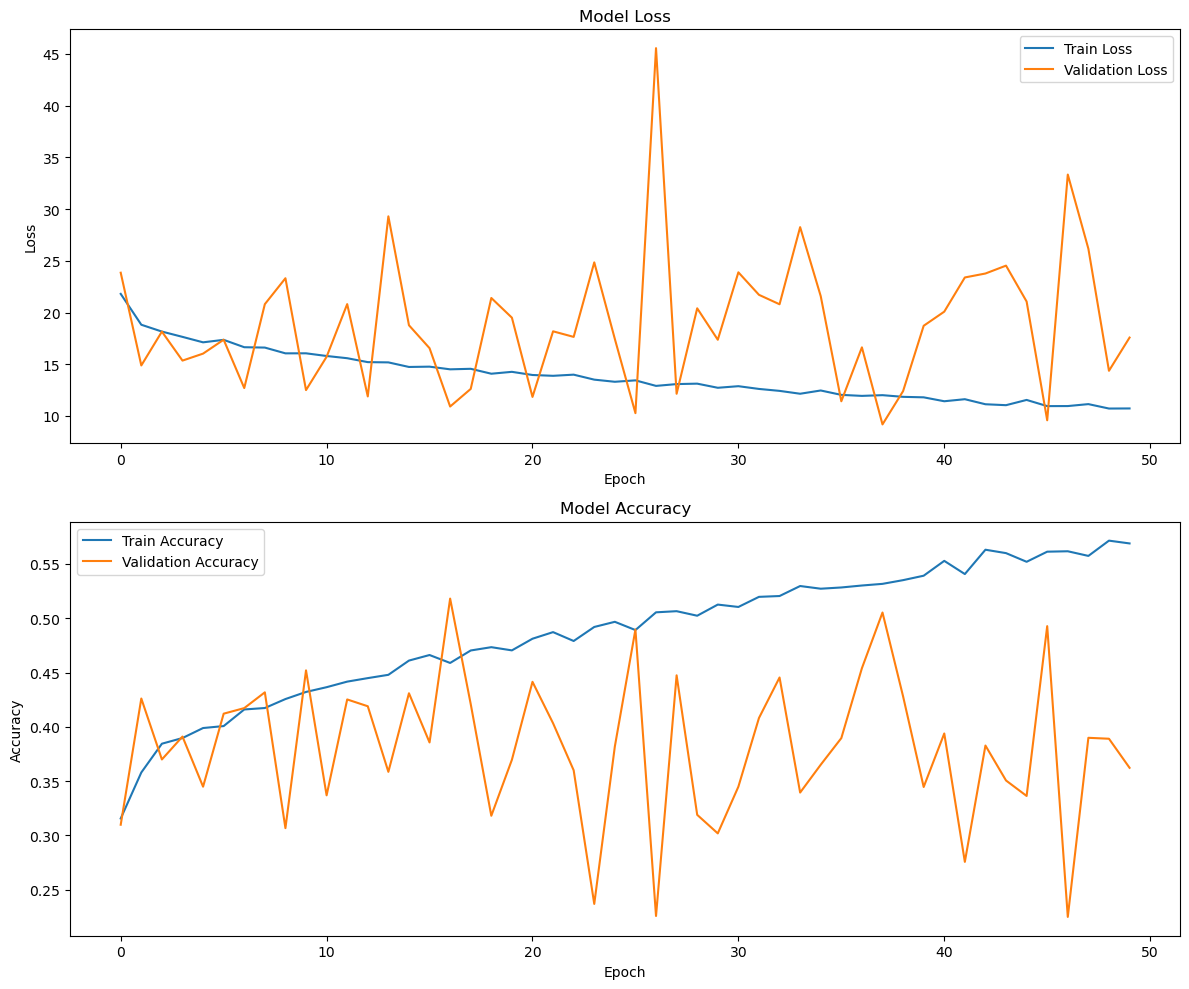

In [26]:
btb_history = trained_btb_model['history']
history_df = pd.DataFrame(btb_history.history)
plot_training(history_df)

## Developing a model that overfits

In [27]:
# graphically and in text demonstrate the overfitting ( )

In [30]:
ML_model = set_up_dnn_model(hidden_layers=1,
                               neurons=32,
                               activation='relu',
                               input_dimension=input_dim,
                               output_dimension=output_class,
                               metrics=multi_metrics,
                               name='Multi_Layer_model')

ML_model.summary()

Model: "Multi_Layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                2160032   
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2160230 (8.24 MB)
Trainable params: 2160230 (8.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
trained_ML_model = train_dnn(ML_model,
                             X_train, y_train,
                             X_val, y_val,
                             epochs=300, 
                             callbacks=[])

In [32]:
print('Accuracy   : {:.2f}%'.format(trained_ML_model['val_score'][0]*100))
print('Precision  : {:.2f}%'.format(trained_ML_model['val_score'][1]*100))
print('Recall     : {:.2f}%'.format(trained_ML_model['val_score'][2]*100))
print('AUC        : {:.2f}%'.format(trained_ML_model['val_score'][3]*100))

Accuracy   : 50.16%
Precision  : 54.67%
Recall     : 46.08%
AUC        : 79.94%


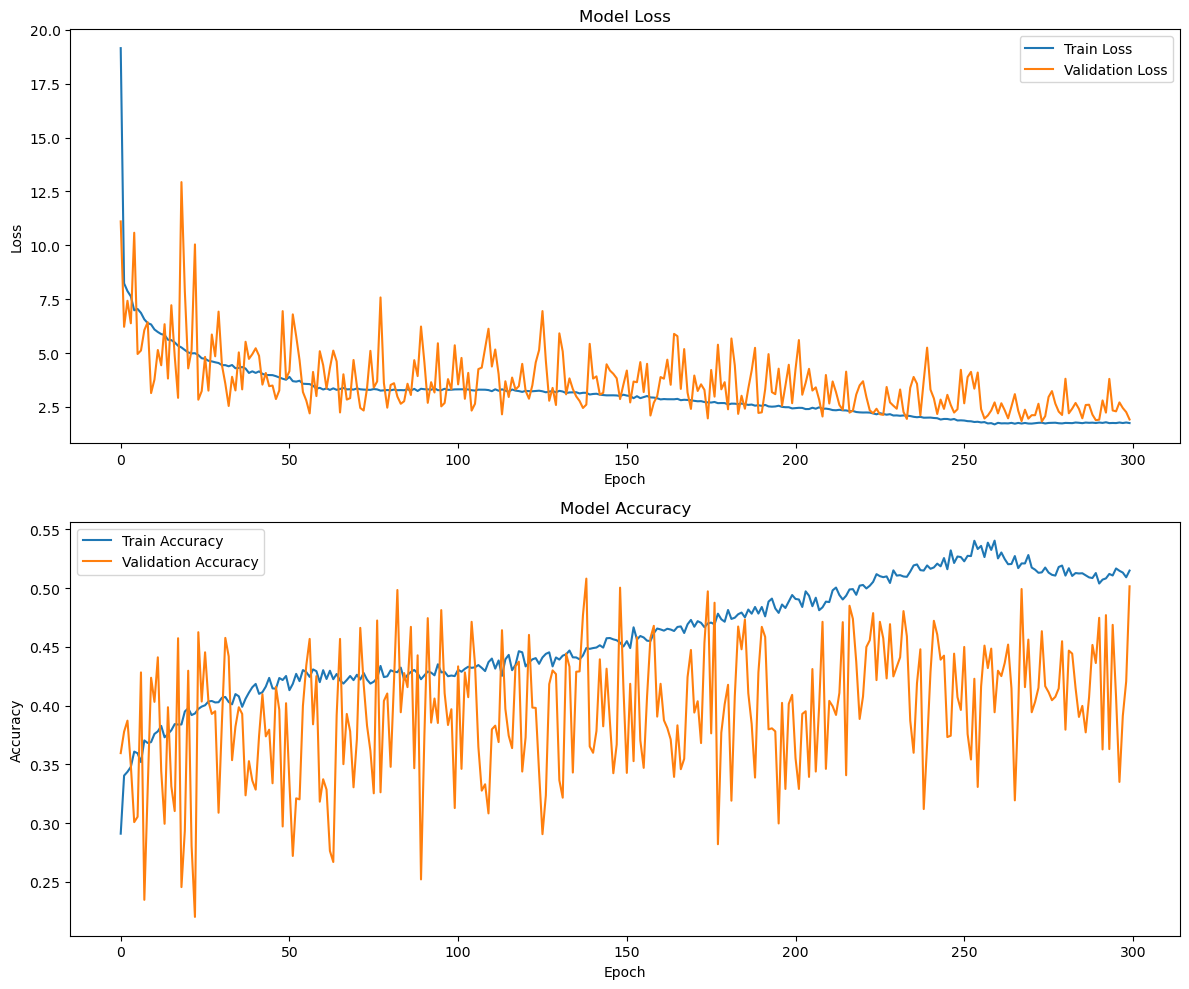

In [33]:
ML_history = trained_ML_model['history']
ML_history_df = pd.DataFrame(ML_history.history)
plot_training(ML_history_df)

# Regularizing your model and tuning your hyperparameters

In [ ]:
# graphically and in text demonstrate the regularizing and tuning the hyperparameters 

In [27]:
number_of_fold = 3
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10, verbose=1)

orders = {
    0: 'categorical_accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

parameters= {
'hidden_layers': [1,2],
'neurons': [8,16, 32 ,64],
'activation': ['relu'],
'dropout': [0.25, 0.5],
}

In [28]:

def grid_search_cv(X, y, parameters, cv, metrics, order={}, my_seed=None):
    np.random.seed(my_seed)
        
    results = []
    for param_combo in [dict(zip(parameters.keys(), values)) for values in itertools.product(*parameters.values())]: 
        kfold = KFold(n_splits=cv, shuffle=True, random_state=my_seed)
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
            train_X, val_X = X[train_idx], X[val_idx]
            train_y, val_y = y[train_idx], y[val_idx]
            
            # create the model using the provided parameters
            hyp_model = set_up_dnn_model(hidden_layers=param_combo['hidden_layers'],
                                         neurons=param_combo['neurons'],
                                         activation=param_combo['activation'],
                                         dropout=param_combo['dropout'],
                                         input_dimension=X.shape[1],
                                         output_dimension=y.shape[1],
                                         metrics=metrics)
            
            # Define Early Stopping Callback
            early_stop = EarlyStopping(monitor='val_loss', patience=5)
                
            # train the model
            result = train_dnn(hyp_model, 
                               train_X,
                               train_y, 
                               val_X,
                               val_y,
                               epochs=50,
                               callbacks=[early_stop])
            
            # Store the result
            result.update(param_combo)
            result['fold'] = fold + 1
            results.append(result)
    
    # Convert the results to DataFrame
    df = pd.DataFrame(results)
    
    return df

In [ ]:
stats = grid_search_cv(X_train,y_train, 
                    parameters,
                    number_of_fold,
                    multi_metrics,
                    order=orders )

In [ ]:
print(stats)

In [ ]:
/////////

### Building the optimal model (with optimal hyperparameters)

In [ ]:
def performance_of_model(y_pred, actual_labels):
    accuracy = metrics.accuracy_score(actual_labels, y_pred)
    precision = metrics.precision_score(actual_labels, y_pred)
    recall = metrics.recall_score(actual_labels, y_pred)
    auc = metrics.roc_auc_score(actual_labels, y_pred, average='weighted', multi_class='ovr')

    print('Accuracy  : {:.2%}'.format(accuracy))
    print('Precision : {:.2%}'.format(precision))
    print('Recall    : {:.2%}'.format(recall))
    print('ROC AUC   : {:.2%}'.format(auc))

    confusion_matrix = metrics.confusion_matrix(actual_labels, y_pred)
    print('Confusion Matrix:')
    print(confusion_matrix)

    performance_report =  classification_report(actual_labels,
                                               y_pred,
                                               target_names=[str(i) for i in range(len(np.unique(actual_labels)))])
    print('Classification Report:')
    print(performance_report)

In [ ]:
optimal_model = set_up_dnn_model(hidden_layers=param_combo['hidden_layers'],
                             neurons=param_combo['neurons'],
                             activation=param_combo['activation'],
                             dropout=param_combo['dropout'],
                             input_dimension=X_train,
                             output_dimension=y_train,
                             metrics=metrics)

optimal_model.summary()

In [ ]:
#train the optimal model 
trained_model = train_dnn(optimal_model, 
                  X_train, 
                  y_train,  
                  X_val,
                  y_val,
                  epochs=100,
                  callbacks=[early_stop])

In [ ]:
y_pred = trained_model.predict(X_test)
performance_of_model(y_pred,y_test)

In [ ]:
///

In [ ]:
# evaluations = trained_model['model'].evaluate(X[validate,:], y[validate,:], verbose=0)[1:]

#         scores.append(evaluations)
#         stopped.append(len(trained_model['history'].history['val_loss']))
#         losses.append(np.min(trained_model['history'].history['val_loss']))
#     stats[str(param_combo)] = {'scores': np.mean(scores, axis=0), 
#                                'epochs': np.mean(stopped), 
#                                'val_loss': np.mean(losses)}